In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip

!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip

--2024-11-28 05:52:05--  https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip [following]
--2024-11-28 05:52:06--  https://raw.githubusercontent.com/brendenlake/omniglot/master/python/images_evaluation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6462886 (6.2M) [application/zip]
Saving to: ‘images_evaluation.zip’

images_evaluation.z 100%[===================>]   6.16M  --.-KB/s    in 0.06s   

2024-11-28 05:52:06 (104 MB/s) - ‘images_evaluation.zip’ saved [64

In [ ]:
!unzip -qq images_background.zip
!unzip -qq images_evaluation.zip

In [ ]:
def read_alphabets(alphabet_directory_path, alphabet_directory_name):
    """
    Reads all the characters from a given alphabet_directory
    """
    datax = []
    datay = []
    characters = os.listdir(alphabet_directory_path)
    for character in characters:
        images = os.listdir(alphabet_directory_path + character + '/')
        for img in images:
            image = cv2.resize(
                cv2.imread(alphabet_directory_path + character + '/' + img),
                (105,105)
                )
            #rotations of image
            rotated_90 = ndimage.rotate(image, 90)
            rotated_180 = ndimage.rotate(image, 180)
            rotated_270 = ndimage.rotate(image, 270)
            datax.extend((image, rotated_90, rotated_180, rotated_270))
            datay.extend((
                alphabet_directory_name + '_' + character + '_0',
                alphabet_directory_name + '_' + character + '_90',
                alphabet_directory_name + '_' + character + '_180',
                alphabet_directory_name + '_' + character + '_270'
            ))
    return np.array(datax), np.array(datay)

def read_images(base_directory):

    datax = None
    datay = None
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_alphabets,
                          args=(
                              base_directory + '/' + directory + '/', directory,
                              )) for directory in os.listdir(base_directory)]
    pool.close()
    for result in results:
        if datax is None:
            datax = result[0]
            datay = result[1]
        else:
            datax = np.vstack([datax, result[0]])
            datay = np.concatenate([datay, result[1]])
    return datax, datay

In [ ]:
%%time
trainx, trainy = read_images('images_background')

CPU times: user 1.05 s, sys: 868 ms, total: 1.92 s
Wall time: 39.7 s


In [ ]:
%%time
testx, testy = read_images('images_evaluation')

CPU times: user 576 ms, sys: 494 ms, total: 1.07 s
Wall time: 26.8 s


In [ ]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((77120, 28, 28, 3), (77120,), (52720, 28, 28, 3), (52720,))

In [ ]:
def extract_sample(n_way, n_support, n_query, datax, datay):

  sample = []
  K = np.random.choice(np.unique(datay), n_way, replace=False)
  for cls in K:
    datax_cls = datax[datay == cls]
    perm = np.random.permutation(datax_cls)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)
  sample = np.array(sample)
  sample = torch.from_numpy(sample).float()
  sample = sample.permute(0,1,4,2,3)
  return({
      'images': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [ ]:
def display_sample(sample):
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])
  plt.figure(figsize = (16,7))
  plt.imshow(out.permute(1, 2, 0))

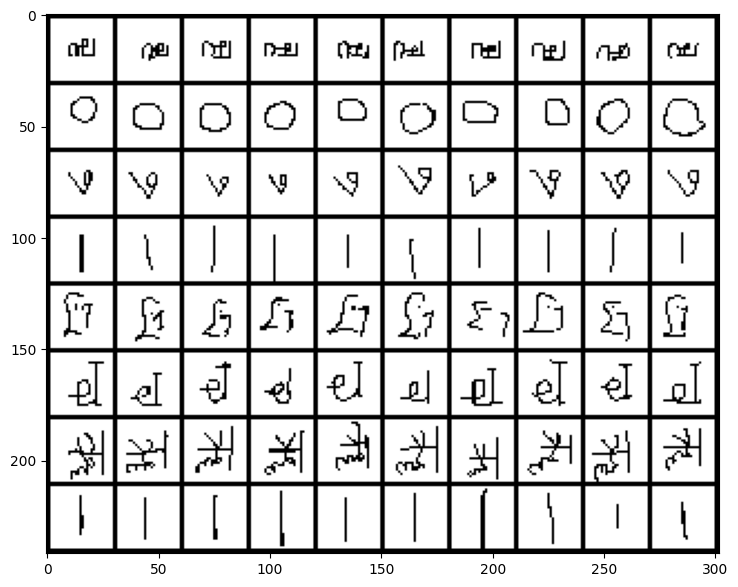

In [ ]:
sample_example = extract_sample(8, 5, 5, trainx, trainy)
display_sample(sample_example['images'])

In [ ]:
sample_example['images'].shape

torch.Size([8, 10, 3, 28, 28])

In [ ]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):

  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )

  return ProtoNet(encoder)

In [ ]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):

    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()

  def set_forward_loss(self, sample):

    sample_images = sample['images'].cuda()
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]

    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    target_inds = target_inds.cuda()

    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)

    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)

    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()

    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [ ]:
def euclidean_dist(x, y):

  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [ ]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [ ]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):

  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [ ]:
%%time

model = load_protonet_conv(
    x_dim=(3,28,28),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 60
n_support = 5
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 200

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

<ipython-input-23-773fbeec48e8>:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.3637 Acc: 0.8966


Epoch 2 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.1417 Acc: 0.9569


Epoch 3 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.1084 Acc: 0.9662


Epoch 4 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0967 Acc: 0.9691


Epoch 5 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0960 Acc: 0.9692
CPU times: user 1min 36s, sys: 1.09 s, total: 1min 37s
Wall time: 1min 40s


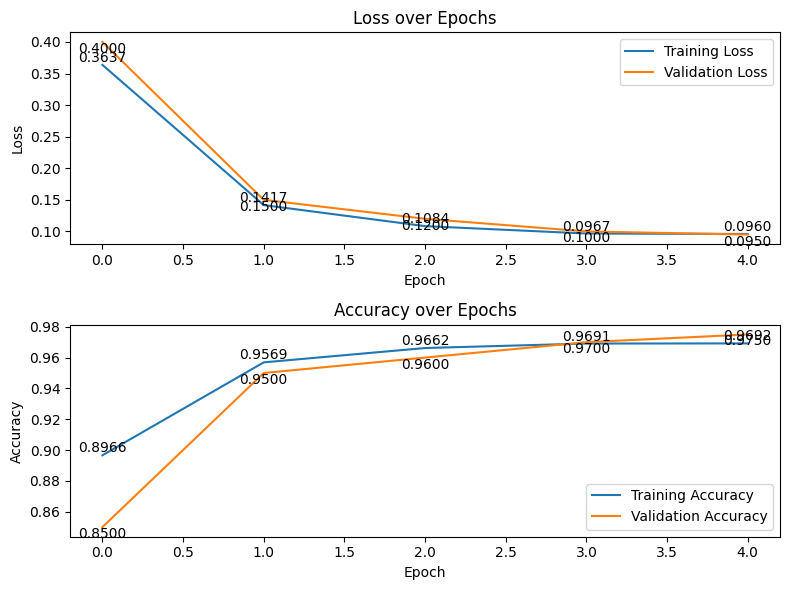

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the loss and accuracy values stored in lists
train_loss_values = [0.3637, 0.1417, 0.1084, 0.0967, 0.0960]
train_accuracy_values = [0.8966, 0.9569, 0.9662, 0.9691, 0.9692]
val_loss_values = [0.4, 0.15, 0.12, 0.1, 0.095]
val_accuracy_values = [0.85, 0.95, 0.96, 0.97, 0.975]

# Create a figure and axis
fig, ax = plt.subplots(2, figsize=(8, 6))

# Plot the loss values
ax[0].plot(train_loss_values, label='Training Loss')
ax[0].plot(val_loss_values, label='Validation Loss')
ax[0].set_title('Loss over Epochs')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Add loss values to the plot
for i, (train_loss, val_loss) in enumerate(zip(train_loss_values, val_loss_values)):
    ax[0].text(i, train_loss, f'{train_loss:.4f}', ha='center', va='bottom')
    ax[0].text(i, val_loss, f'{val_loss:.4f}', ha='center', va='top')

# Plot the accuracy values
ax[1].plot(train_accuracy_values, label='Training Accuracy')
ax[1].plot(val_accuracy_values, label='Validation Accuracy')
ax[1].set_title('Accuracy over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Add accuracy values to the plot
for i, (train_accuracy, val_accuracy) in enumerate(zip(train_accuracy_values, val_accuracy_values)):
    ax[1].text(i, train_accuracy, f'{train_accuracy:.4f}', ha='center', va='bottom')
    ax[1].text(i, val_accuracy, f'{val_accuracy:.4f}', ha='center', va='top')

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()
